# Práctica 1

## Luis Gómez Dios, Pedro Arias Redondo, Mateo Fraguas Abal

In [1]:
!pip install imbalanced-learn

In [2]:
import pandas
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

from imblearn.over_sampling import SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import EditedNearestNeighbours

In [3]:
#Semilla para evitar aleatoriedad
SEED_VALUE=1
np.random.seed(SEED_VALUE)

## 1ºPREPROCESADO DE LOS DATOS

### 1.1ºAcceso a los datos

In [4]:
data = pandas.read_csv('breast-cancer-train.csv'); data #utilizamos pandas para leer el csv

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.38,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.99,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.91,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
3,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.54,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
4,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,...,15.47,23.75,103.40,741.6,0.17910,0.52490,0.5355,0.1741,0.3985,0.12440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,925311,B,11.20,29.37,70.67,386.0,0.07449,0.03558,0.00000,0.00000,...,11.92,38.30,75.19,439.6,0.09267,0.05494,0.0000,0.0000,0.1566,0.05905
419,926125,M,20.92,25.09,143.00,1347.0,0.10990,0.22360,0.31740,0.14740,...,24.29,29.41,179.10,1819.0,0.14070,0.41860,0.6599,0.2542,0.2929,0.09873
420,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.45,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
421,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.98,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820


### 1.2ºLimpieza general de datos

In [5]:
data = data.iloc[:,1:] #quitamos la variable id porque no aporta valor para la predicción
data = data.drop_duplicates() #eliminamos las observaciones duplicadas
data.reset_index(drop=True, inplace=True) #reiniciamos los índices
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0}) #Cambiamos las variables categóricas por numéricas

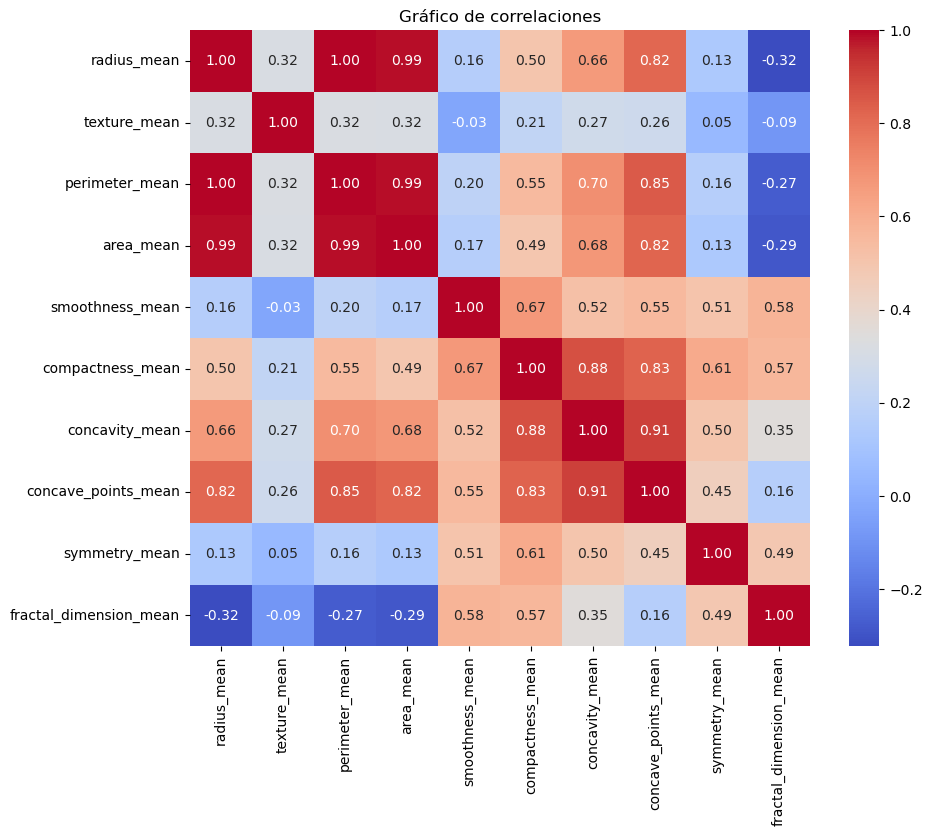

In [6]:
#Miramos las correlaciones
plt.figure(figsize=(10, 8))
sns.heatmap(data.iloc[:,1:11].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Gráfico de correlaciones')
plt.show()

Observamos que las variables radio, perímetro y area están completamente correladas (como es de esperar) por lo tanto nos quedamos solamente con una de las 3 ya que las otras no aportan información adicional. En este caso nos quedamos solo con radio.

In [7]:
data.drop(columns=['perimeter_mean','area_mean','perimeter_sd','area_sd','perimeter_worst','area_worst'],inplace=True)
data.head()

,diagnosis,radius_mean,texture_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_sd,...,symmetry_sd,fractal_dimension_sd,radius_worst,texture_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,...,0.03003,0.006193,25.38,17.33,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,...,0.01389,0.003532,24.99,23.41,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,11.42,20.38,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,...,0.05963,0.009208,14.91,26.50,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
3,1,20.29,14.34,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,...,0.01756,0.005115,22.54,16.67,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
4,1,12.45,15.70,0.12780,0.17000,0.1578,0.08089,0.2087,0.07613,0.3345,...,0.02165,0.005082,15.47,23.75,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440


### 1.3ºGestión de MissingValues

In [8]:
any(pandas.isna(data)) #avisa de la existencia de missing values en los datos

True

In [9]:
pandas.isna(data).sum() #muestra cuantos MVs tiene cada parámetro

diagnosis                   0
radius_mean                 0
texture_mean                0
smoothness_mean             0
compactness_mean            0
concavity_mean              0
concave_points_mean         0
symmetry_mean               0
fractal_dimension_mean      0
radius_sd                  42
texture_sd                 37
smoothness_sd              35
compactness_sd             22
concavity_sd               12
concave_points_sd          13
symmetry_sd                13
fractal_dimension_sd       16
radius_worst                0
texture_worst               0
smoothness_worst            0
compactness_worst           0
concavity_worst             0
concave_points_worst        0
symmetry_worst              0
fractal_dimension_worst     0
dtype: int64

In [10]:
pandas.isna(data).sum().sum() #muestra cuantos MVs hay en total

190

In [11]:
#**Imputación iterativa**
IteImp = IterativeImputer(max_iter=20)
data_IteImp = IteImp.fit_transform(data)
data_IteImp = pandas.DataFrame(data_IteImp, columns=data.columns) 
data = data_IteImp #reemplazamos la variable principal data por los datos resultantes del método de imputación seleccionado para más claridad

In [12]:
'''#**Eliminación de las filas con MVs**
data_noMVs = data.dropna(); data_noMVs.shape 
data_noMVs.reset_index(drop=True, inplace=True)

#**Imputación simple (usando la mediana)**
SimpImp = SimpleImputer(missing_values = np.nan,strategy = 'median')
data_SimpImp = SimpImp.fit_transform(data)
data_SimpImp = pandas.DataFrame(data_SimpImp, columns=data.columns)

#**Imputación mediante los k vecinos más cercanos KNN**
KNNImp = KNNImputer(n_neighbors=3, weights="uniform")
data_KNNImp = KNNImp.fit_transform(data)
data_KNNImp = pandas.DataFrame(data_KNNImp, columns=data.columns)'''

'#**Eliminación de las filas con MVs**\ndata_noMVs = data.dropna(); data_noMVs.shape \ndata_noMVs.reset_index(drop=True, inplace=True)\n\n#**Imputación simple (usando la mediana)**\nSimpImp = SimpleImputer(missing_values = np.nan,strategy = \'median\')\ndata_SimpImp = SimpImp.fit_transform(data)\ndata_SimpImp = pandas.DataFrame(data_SimpImp, columns=data.columns)\n\n#**Imputación mediante los k vecinos más cercanos KNN**\nKNNImp = KNNImputer(n_neighbors=3, weights="uniform")\ndata_KNNImp = KNNImp.fit_transform(data)\ndata_KNNImp = pandas.DataFrame(data_KNNImp, columns=data.columns)'

### 1.4ºDetección de datos atípicos

In [13]:
ground_truth = np.ones(len(data), dtype=int) #lista de 1s
clf = LocalOutlierFactor(n_neighbors=20) #función para detectar datos atípicos
y_pred = clf.fit_predict(data) #lista de 1s(se considera una observación normal) y -1s(se considera atípica)
outliers = np.where(y_pred == -1)[0]

print("Observaciones atípicas:\n", outliers)
print(len(outliers))

Observaciones atípicas:
 [  0   3  59 117 121 135 142 153 158 167 173 186 189 230 296 351 365 418]
18


Finalmente decidimos no eliminar los datos atípicos por si pudieran ser relevantes y simplemente mitigaremos su impacto mediante la normalización de los datos.

### 1.5ºDatos desbalanceados

In [14]:
#Dividimos los datos
X = data.iloc[:,1:]
y = data.iloc[:,0:1]

In [15]:
y.value_counts()#muestra cuantos datos hay de cada clase

diagnosis
0.0          282
1.0          137
Name: count, dtype: int64

Observamos que los datos presentan cierto desbalance. Hay más del doble de datos clasificados como benignos que como malignos.

In [16]:
#Técnica mixta de oversampling con undersampling (con ENN)
st = SMOTEENN(random_state=SEED_VALUE) 
print(y.value_counts())
X, y = st.fit_resample(X, y) #Actualizamos nuestros datos
print(y.value_counts())

diagnosis
0.0          282
1.0          137
Name: count, dtype: int64
diagnosis
1.0          249
0.0          247
Name: count, dtype: int64


In [17]:
#Técnica de oversampling
'''sm = SVMSMOTE(random_state=SEED_VALUE)
print(y.value_counts())
X_res, y_res = sm.fit_resample(X, y)
print(y_res.value_counts())'''

'sm = SVMSMOTE(random_state=SEED_VALUE)\nprint(y.value_counts())\nX_res, y_res = sm.fit_resample(X, y)\nprint(y_res.value_counts())'

In [18]:
#Técnica mixta de oversampling con undersampling (con Tomek’s link)
'''stomek = SMOTETomek(random_state=SEED_VALUE)
print(y.value_counts())
X_res, y_res = stomek.fit_resample(X, y)
print(y_res.value_counts())'''

'stomek = SMOTETomek(random_state=SEED_VALUE)\nprint(y.value_counts())\nX_res, y_res = stomek.fit_resample(X, y)\nprint(y_res.value_counts())'

### 1.6ºNormalización

In [19]:
scaler = StandardScaler()
X_data = scaler.fit_transform(X)
X = pandas.DataFrame(X_data, columns=X.columns)
X.head(n=5)

,radius_mean,texture_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_sd,texture_sd,...,symmetry_sd,fractal_dimension_sd,radius_worst,texture_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,-0.466904,-0.901874,0.794827,0.328471,-0.706697,-0.644508,0.577284,0.834478,-0.956138,-0.841301,...,-0.429271,-0.544677,-0.545661,-0.908702,-0.148076,0.051661,-0.544714,-0.811455,0.456990,-0.182571
1,-1.429431,-1.658395,0.401433,-0.861047,-0.909614,-0.906266,-0.028279,0.974563,-0.629782,-0.393042,...,-0.006796,-0.327987,-1.373868,-1.693898,-0.092147,-1.043711,-1.037158,-0.967727,-0.828233,-0.438416
2,-1.781496,-0.640446,-0.863598,-0.966241,-1.081817,-1.282017,-0.211541,0.375474,-1.058545,-0.432370,...,0.655364,-0.482025,-1.619421,-0.669729,-0.217987,-0.903089,-1.134685,-1.509794,0.318662,-0.665556
3,-0.744142,-1.151734,0.455429,-0.362859,-0.451918,-0.735896,-0.586034,-0.310050,-0.678328,-0.877107,...,-0.731903,-0.545874,-0.689191,-0.874563,0.700185,-0.365495,0.024642,-0.920223,-0.308191,-0.108938
4,-0.316173,-0.756122,-1.569393,-0.944014,-1.047955,-0.995628,-1.868872,-0.444175,-0.949051,-0.497525,...,-0.856588,-0.494396,-0.512687,-0.469772,-1.187428,-0.751701,-0.957006,-0.618631,-1.010335,-0.281165


## 2ºREDUCIÓN DE DIMESIONALIDAD

In [20]:
y = y.values.ravel() #esto es para arreglar un asunto de formato

**Método del codo con SelectKBest**

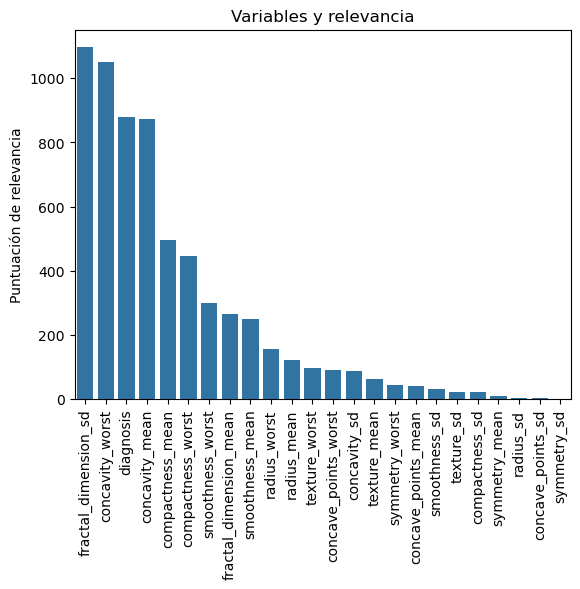

In [21]:
#Columnas de X
n_columnas = X.shape[1]

SKB = SelectKBest(k='all').fit(X, y)
scores = SKB.scores_;scores
scores = list(zip(scores,[i for i in range(n_columnas)]))#lista de tuplas con los scores y los índices de sus variables

sorted_scores = sorted(scores, key=lambda x: x[0],reverse=True) #La lista scores ordenada según la puntuación de los scores de mayor a menor

#plot

scores = [score[0] for score in sorted_scores]
variables_sorted = [data.columns[score[1]] for score in sorted_scores]
scores_plot = sns.barplot(x=variables_sorted,y=scores)
plt.xticks(rotation=90)
plt.title('Variables y relevancia')
plt.ylabel('Puntuación de relevancia')
plt.show()

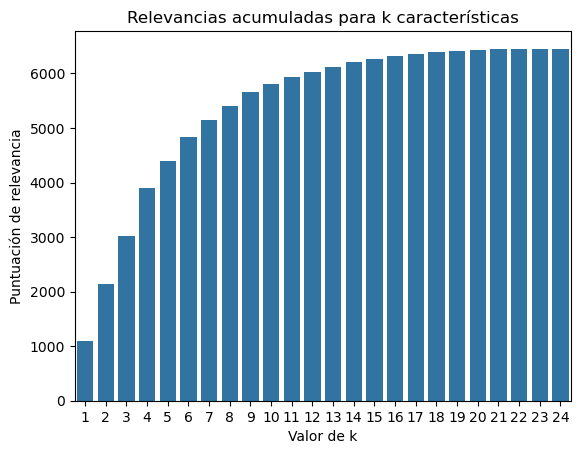

In [22]:
def relevancia_k(scores): #acumulación de las relevancias
    orig = scores[:]
    relevancia = []
    while len(scores) != 1:
        if len(relevancia) == 0:
            relevancia.append(sum(scores))
        else:
            relevancia.append(relevancia[-1]-scores[-1])
            scores = np.delete(scores,-1)
    scores = orig[:]
    return relevancia

scores = SKB.scores_;scores
sorted_scores = np.sort(scores)[::-1]
relevancia = relevancia_k(sorted_scores)
relevancia.reverse()

#plot

#relevancia acumulada de las k características seleccionadas
scores = sns.barplot(x=[i for i in range(1,n_columnas+1)],y=relevancia)
plt.title('Relevancias acumuladas para k características')
plt.xlabel('Valor de k')
plt.ylabel('Puntuación de relevancia')
plt.show()

**Modelos y pareto**

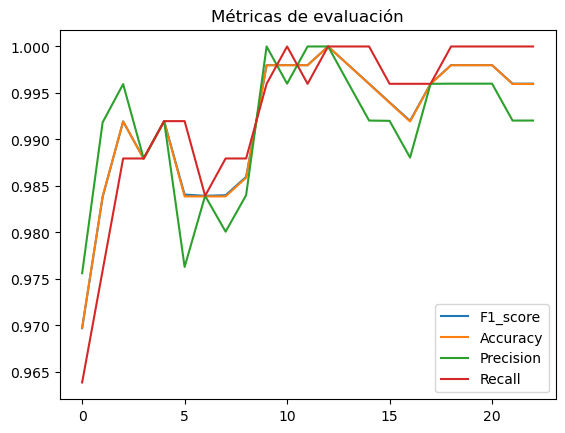

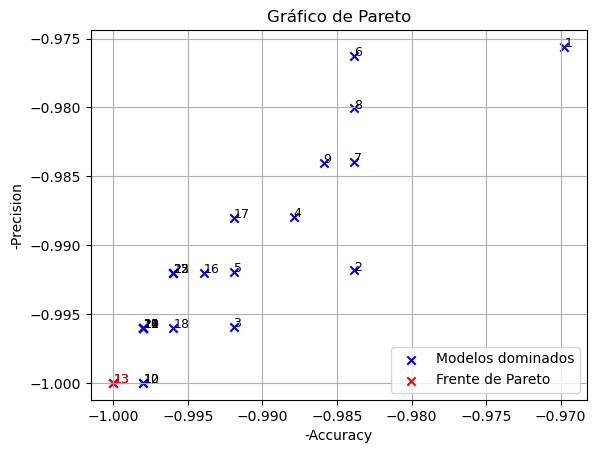

In [23]:
KNN = KNeighborsClassifier()

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for k in range(1,n_columnas):
    X_new = SelectKBest(k=k).fit_transform(X, y)

    KNN.fit(X_new,y)
    y_pred = KNN.predict(X_new)
    accuracy = accuracy_score(y,y_pred)
    accuracy_list.append(accuracy)
    precision = precision_score(y,y_pred)
    precision_list.append(precision)
    recall = recall_score(y,y_pred)
    recall_list.append(recall)
    f1 = f1_score(y,y_pred)
    f1_list.append(f1)


plt.plot(f1_list,label='F1_score')
plt.plot(accuracy_list,label='Accuracy')
plt.plot(precision_list,label='Precision')
plt.plot(recall_list,label='Recall')
plt.title('Métricas de evaluación')
plt.legend(loc='lower right')
plt.show()

#Pareto
puntos = [[-i,-j] for i, j in zip(accuracy_list, precision_list)]
puntos = [(puntos[i],i+1) for i in range(len(puntos))]


def obtener_frente_pareto(puntos):
    is_pareto = [True] * len(puntos)
    
    for i in range(len(puntos)):
        if is_pareto[i]:
            for j in range(len(puntos)):
                if i != j:
                    if np.any(puntos[j][0] < puntos[i][0]):
                        is_pareto[i] = False
                        break  # Salimos del bucle ya que el punto fue dominado

    return is_pareto


frente_pareto = obtener_frente_pareto(puntos)
frente, no_frente = [], []
for i in range(len(frente_pareto)):
    (frente if frente_pareto[i] else no_frente).append(puntos[i])

        

x_puntos, y_puntos, labels_puntos = zip(*[(p[0][0], p[0][1], p[1]) for p in puntos])
x_frente, y_frente, labels_frente = zip(*[(p[0][0], p[0][1], p[1]) for p in frente])

# Modelos dominados
plt.scatter(x_puntos, y_puntos, color='blue', label='Modelos dominados',marker = 'x')
for i, label in enumerate(labels_puntos):
    plt.text(x_puntos[i], y_puntos[i], str(label), fontsize=9)

# Frente
plt.scatter(x_frente, y_frente, color='red', label='Frente de Pareto', marker='x')
for i, label in enumerate(labels_frente):
    plt.text(x_frente[i], y_frente[i], str(label), fontsize=9, color='red')


plt.title('Gráfico de Pareto')
plt.xlabel('-Accuracy')
plt.ylabel('-Precision')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [24]:
print('Cantidad de modelos en el frente de Pareto:',len(frente))

Cantidad de modelos en el frente de Pareto: 1


In [25]:
print('Dimensiones de X:',X.shape)
X = SelectKBest(k=13).fit_transform(X, y)
print('Nuevas dimensiones de X:',X.shape)

Dimensiones de X: (496, 24)
Nuevas dimensiones de X: (496, 13)


### 3ºCreación y validación de modelos

In [26]:
#Dividimos los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED_VALUE, stratify=y, train_size = 0.8) #80% train, 20% tests

#Usamos el Grid_search_CV
modelo = KNeighborsClassifier()

param_grid = {
    'n_neighbors': list(range(1,11)), #Más vecinos pueden hacer que el modelo sea menos flexible
    'weights': ['uniform', 'distance'],  
    'leaf_size': [30]   
}


# Búsqueda con validación cruzada, con 5 folds. Se busca maximizar el accuracy.
#n_jobs introduce paralelización para que el grid_search sea más rápido
grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid, cv=5, scoring='accuracy',n_jobs=-1)

grid_search.fit(X_train, y_train) #Entrenamiento del modelo y búsqueda de la mejor combinación de hiperparámetros

mejores_modelos = grid_search.cv_results_['rank_test_score'] #ranking de los mejores modelos
mejores_modelos = [i for i in range(len(mejores_modelos)) if mejores_modelos[i]==1] #Coge los modelos que han empatado en accuracy
min_sd = min([grid_search.cv_results_['std_test_score'][i] for i in mejores_modelos]) #Calcula la desviación típica mínima que se ha obtenido entre los mejore modelos
mejores_modelos = [i for i in mejores_modelos if grid_search.cv_results_['std_test_score'][i] == min_sd] #elimina los modelos dentro de mejores modelos con más desviación típica
mejores_modelos = [grid_search.cv_results_['params'][i] for i in mejores_modelos] #cambio los índices por los parámetros

print('Usaremos los modelos con los siguientes parámetros:',mejores_modelos)

Usaremos los modelos con los siguientes parámetros: [{'leaf_size': 30, 'n_neighbors': 5, 'weights': 'uniform'}, {'leaf_size': 30, 'n_neighbors': 5, 'weights': 'distance'}, {'leaf_size': 30, 'n_neighbors': 8, 'weights': 'distance'}]


In [27]:
print('Cantidad de modelos explorados:\n', len(grid_search.cv_results_['params']))

Cantidad de modelos explorados:
 20


**Generabilidad de los modelos**

In [28]:
modelo1 = KNeighborsClassifier(n_neighbors=5,weights='uniform',leaf_size = 30)
modelo2 = KNeighborsClassifier(n_neighbors=5,weights='distance',leaf_size = 30)
modelo3 = KNeighborsClassifier(n_neighbors=8,weights='distance',leaf_size = 30)


m1_mean_accuracy = [];m1_mean_recall = []
m2_mean_accuracy = [];m2_mean_recall = []
m3_mean_accuracy = [];m3_mean_recall = []


n_repeticiones = 10
for seed in range(n_repeticiones):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, stratify=y, train_size = 0.8) #80% train, 20% tests
    modelo1.fit(X_train,y_train)
    modelo2.fit(X_train,y_train)
    modelo3.fit(X_train,y_train)
    y_pred_m1 = modelo1.predict(X_test)
    y_pred_m2 = modelo2.predict(X_test)
    y_pred_m3 = modelo3.predict(X_test)
    
    m1_mean_accuracy.append(modelo1.score(X_test,y_test)) #accuracy
    m2_mean_accuracy.append(modelo2.score(X_test,y_test))
    m3_mean_accuracy.append(modelo3.score(X_test,y_test))
    m1_mean_recall.append(recall_score(y_test, y_pred_m1))
    m2_mean_recall.append(recall_score(y_test, y_pred_m2))
    m3_mean_recall.append(recall_score(y_test, y_pred_m3))



print('Accuracys modelo1:',m1_mean_accuracy,'| Recalls modelo1:',m1_mean_recall)
print('Accuracys modelo2:',m2_mean_accuracy,'| Recalls modelo2:',m2_mean_recall)
print('Accuracys modelo3:',m3_mean_accuracy,'| Recalls modelo3:',m3_mean_recall)
print('\nMedia de accuracys modelo1:',np.mean(m1_mean_accuracy),'| Media de recalls modelo1:',np.mean(m1_mean_recall))
print('Media de accuracys modelo2:',np.mean(m2_mean_accuracy),'| Media de recalls modelo2:',np.mean(m2_mean_recall))
print('Media de accuracys modelo3:',np.mean(m3_mean_accuracy),'| Media de recalls modelo3:',np.mean(m3_mean_recall))


Accuracys modelo1: [0.97, 1.0, 0.98, 0.98, 0.98, 0.98, 1.0, 0.99, 0.97, 0.99] | Recalls modelo1: [0.98, 1.0, 0.98, 1.0, 0.98, 0.98, 1.0, 0.98, 0.96, 0.98]
Accuracys modelo2: [0.97, 1.0, 0.98, 0.98, 0.98, 0.98, 1.0, 0.99, 0.97, 0.99] | Recalls modelo2: [0.98, 1.0, 0.98, 1.0, 0.98, 0.98, 1.0, 0.98, 0.96, 0.98]
Accuracys modelo3: [0.99, 1.0, 0.99, 0.99, 0.99, 0.99, 1.0, 0.99, 0.99, 1.0] | Recalls modelo3: [1.0, 1.0, 1.0, 1.0, 0.98, 0.98, 1.0, 0.98, 1.0, 1.0]

Media de accuracys modelo1: 0.984 | Media de recalls modelo1: 0.984
Media de accuracys modelo2: 0.984 | Media de recalls modelo2: 0.984
Media de accuracys modelo3: 0.993 | Media de recalls modelo3: 0.994


Seleccionamos el modelo3 (correspondiente a los parámetros {'leaf_size': 30, 'n_neighbors': 8, 'weights': 'distance'}) por ser el que mejor rendimiento ha ofrecido para las métricas de evaluación accuracy y recall.

**Modelo final**

In [29]:
#El modelo seleccionado es el siguiente:
modelo_final = KNeighborsClassifier(n_neighbors=8,weights='distance',leaf_size = 30)
modelo_final.fit(X,y)

KNeighborsClassifier(n_neighbors=8, weights='distance')

**Prueba del modelo final**

**Remplazar el nombre de los datos en la siguiente celda y ejecutar**

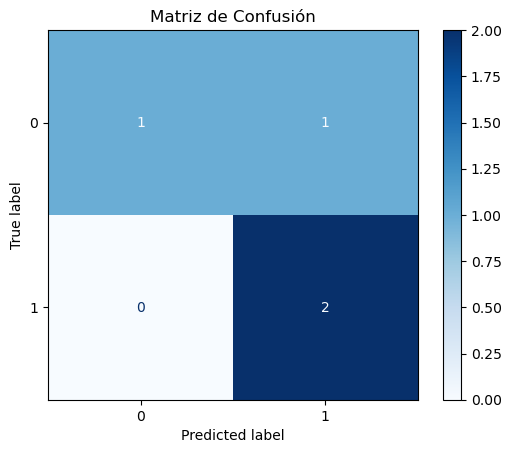

Accuracy: 0.75


In [30]:
new_data = pandas.read_csv('breast-cancer-test1.csv')

#limpieza general
new_data = new_data.iloc[:,1:] #quito la variable id porque no aporta valor para la predicción
new_data['diagnosis'] = new_data['diagnosis'].map({'M': 1, 'B': 0}) #Cambio las variables categóricas por numéricas
new_data.drop(columns=['perimeter_mean','area_mean','perimeter_sd','area_sd','perimeter_worst','area_worst'],inplace=True)

#División
X_new = new_data.iloc[:,1:]
y_new = new_data.iloc[:,0:1]

#Estandarización
scaler = StandardScaler()
X_new_data = scaler.fit_transform(X_new)
X_new = pandas.DataFrame(X_new_data, columns=X_new.columns)

#Adaptamos el nuevo dataset al tamaño del input del modelo
X_new.drop(columns=variables_sorted[13:],inplace=True)
X_new.shape

#Comprobamos la accuracy del modelo de manera visual y numérica
y_pred_new = modelo_final.predict(X_new.to_numpy()) #Lo convertimos a numpy para evitar un warning

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_new, y_pred_new))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

print('Accuracy:', modelo_final.score(X_new.to_numpy(),y_new))